# Titanic: logistic regression

In [541]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [542]:
train = pd.read_csv('data/train.csv')

## Exploratiry analysis

In [543]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [544]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Look for correlations

In [545]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


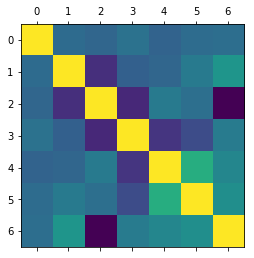

In [546]:
plt.matshow(train.corr())
plt.show()

In [547]:
train['sex_binary'] = np.where(train['Sex'].eq('male'), 1, 0)

In [548]:
train['sex_binary'].corr(train['Survived'])

-0.5433513806577551

In [549]:
train.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,sex_binary
Sex,,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818,0.0
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,25.523893,1.0


In [550]:
train[train['Fare']>80].mean()

PassengerId    456.216216
Survived         0.770270
Pclass           1.000000
Age             32.371940
SibSp            0.675676
Parch            0.702703
Fare           158.678826
sex_binary       0.351351
dtype: float64

## Data preparation

In [551]:
from sklearn.preprocessing import StandardScaler

In [552]:
def prepare_input_data_for_modelling(df):
    
    ret = df.copy()
    ret.drop(['PassengerId', 'Name'], axis=1, inplace=True)
    for col_name in ret.columns:
        if(ret[col_name].dtype == 'object'):
            ret[col_name]= ret[col_name].astype('category')
            ret[col_name] = ret[col_name].cat.codes
        ret[col_name].fillna((ret[col_name].median()), inplace=True)
    sc = StandardScaler()
    ret = pd.DataFrame(sc.fit_transform(ret))
    return ret

In [553]:
def prepare_target_data_for_modelling(target_data):
    data = target_data[['Survived']].copy()
    return data

In [554]:
Y_train = prepare_target_data_for_modelling(train)
X_train = prepare_input_data_for_modelling(train.drop(['Survived', 'sex_binary'], axis=1))
print(X_train.describe(include='all'))

                  0             1             2             3             4  \
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02   
mean  -2.031048e-16 -4.059603e-16  3.841546e-16  3.456519e-16  6.716164e-17   
std    1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00   
min   -1.566107e+00 -1.355574e+00 -2.224156e+00 -4.745452e-01 -4.736736e-01   
25%   -3.693648e-01 -1.355574e+00 -5.657365e-01 -4.745452e-01 -4.736736e-01   
50%    8.273772e-01  7.376951e-01 -1.046374e-01 -4.745452e-01 -4.736736e-01   
75%    8.273772e-01  7.376951e-01  4.333115e-01  4.327934e-01 -4.736736e-01   
max    8.273772e-01  7.376951e-01  3.891554e+00  6.784163e+00  6.974147e+00   

                  5             6             7             8  
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  
mean   4.859562e-17 -4.373606e-17  3.949952e-17  5.146152e-17  
std    1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  
min   -1.686421e+00 -6.484217e-0

/home/dmitry/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/dmitry/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Prepare Test data

In [555]:
test = pd.read_csv('data/test.csv')
print(test.describe(include='all'))
X_test = prepare_input_data_for_modelling(test)
print(X_test.describe(include='all'))

        PassengerId      Pclass                Name   Sex         Age  \
count    418.000000  418.000000                 418   418  332.000000   
unique          NaN         NaN                 418     2         NaN   
top             NaN         NaN  Minkoff, Mr. Lazar  male         NaN   
freq            NaN         NaN                   1   266         NaN   
mean    1100.500000    2.265550                 NaN   NaN   30.272590   
std      120.810458    0.841838                 NaN   NaN   14.181209   
min      892.000000    1.000000                 NaN   NaN    0.170000   
25%      996.250000    1.000000                 NaN   NaN   21.000000   
50%     1100.500000    3.000000                 NaN   NaN   27.000000   
75%     1204.750000    3.000000                 NaN   NaN   39.000000   
max     1309.000000    3.000000                 NaN   NaN   76.000000   

             SibSp       Parch    Ticket        Fare            Cabin Embarked  
count   418.000000  418.000000       418  

/home/dmitry/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/dmitry/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Select the model

In [556]:
model_voting_classifier = "Voting Classifier"
model_neural_network = "Neural Network"

In [557]:
model = model_neural_network

## Voting Classifier

In [558]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

def voting_classifier_train_and_predict(X_train, Y_train, X_test):
    clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
    clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
    clf3 = GaussianNB()

    vote_cls = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard', weights=[0.2,0.5,0.3])
    vote_cls.fit(X_train, Y_train)
    
    return vote_cls.predict(X_test)    

## Neural Network

In [559]:
from keras import Sequential
from keras.layers import Dense

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=9))
#Second  Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [560]:
def neural_network_train_and_predict(X_train, Y_train, X_test):
    classifier.fit(X_train, Y_train, batch_size=10, epochs=100)
    y_pred=classifier.predict(X_test)
    y_pred = [(1 if (p>0.5) else 0) for p in y_pred]
    return y_pred

## Train the model and make predictions for the Test Data Set

In [561]:
if model == model_voting_classifier:
    Y_test = voting_classifier_train_and_predict(X_train, Y_train, X_test)
elif model == model_neural_network:
    Y_test = neural_network_train_and_predict(X_train, Y_train, X_test)
else:
    raise Exception(f'Model {model} is not supported')

Epoch 1/100
891/891 [==============================] - 0s 391us/step - loss: 0.6885 - acc: 0.6184
Epoch 2/100
891/891 [==============================] - 0s 115us/step - loss: 0.6576 - acc: 0.6162
Epoch 3/100
891/891 [==============================] - 0s 140us/step - loss: 0.5828 - acc: 0.7419
Epoch 4/100
891/891 [==============================] - 0s 127us/step - loss: 0.5170 - acc: 0.7980
Epoch 5/100
891/891 [==============================] - 0s 154us/step - loss: 0.4822 - acc: 0.8025
Epoch 6/100
891/891 [==============================] - 0s 124us/step - loss: 0.4645 - acc: 0.8070
Epoch 7/100
891/891 [==============================] - 0s 126us/step - loss: 0.4540 - acc: 0.8103
Epoch 8/100
891/891 [==============================] - 0s 130us/step - loss: 0.4482 - acc: 0.8114
Epoch 9/100
891/891 [==============================] - 0s 130us/step - loss: 0.4445 - acc: 0.8114
Epoch 10/100
891/891 [==============================] - 0s 128us/step - loss: 0.4416 - acc: 0.8081
Epoch 11/100
891/89

891/891 [==============================] - 0s 153us/step - loss: 0.3996 - acc: 0.8294
Epoch 84/100
891/891 [==============================] - 0s 121us/step - loss: 0.3986 - acc: 0.8305
Epoch 85/100
891/891 [==============================] - 0s 108us/step - loss: 0.3979 - acc: 0.8339
Epoch 86/100
891/891 [==============================] - 0s 114us/step - loss: 0.3976 - acc: 0.8350
Epoch 87/100
891/891 [==============================] - 0s 110us/step - loss: 0.3977 - acc: 0.8305
Epoch 88/100
891/891 [==============================] - 0s 103us/step - loss: 0.3973 - acc: 0.8328
Epoch 89/100
891/891 [==============================] - 0s 115us/step - loss: 0.3975 - acc: 0.8361
Epoch 90/100
891/891 [==============================] - 0s 109us/step - loss: 0.3975 - acc: 0.8350
Epoch 91/100
891/891 [==============================] - 0s 115us/step - loss: 0.3969 - acc: 0.8339
Epoch 92/100
891/891 [==============================] - 0s 102us/step - loss: 0.3975 - acc: 0.8373
Epoch 93/100
891/891 [=

In [562]:
prediction = test[['PassengerId']].copy()
prediction['Survived'] = Y_test
prediction = prediction.set_index('PassengerId')
prediction.to_csv('prediction/result.csv')
prediction.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,0


## Submit the prediction to Kaggle

In [563]:
!kaggle competitions submit -c titanic -f prediction/result.csv -m '{model}'

100%|████████████████████████████████████████| 2.77k/2.77k [00:05<00:00, 555B/s]
Successfully submitted to Titanic: Machine Learning from Disaster